In [1]:
# pip install torch==2.5.1+cu121 --index-url https://download.pytorch.org/whl/cu121
# pip install -U transformers datasets peft trl bitsandbytes accelerate
# pip install pandas matplotlib
# pip install peft

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, pipeline
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, PeftModel
from trl import SFTTrainer
import pandas as pd
import matplotlib.pyplot as plt

print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return 0 (or your GPU index)
print(torch.cuda.get_device_name(0))  # Should print your GPU name

# Authenticate with Hugging Face (replace with your token)
from huggingface_hub import login
login(token="HUGGING_FACE_TOKEN")

c:\Users\Jayden\Desktop\llm_fyp_finbert\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
0
NVIDIA GeForce RTX 4060 Ti


Dataset Size: 2264

Sentiment Distribution:
label
1    1391
2     570
0     303
Name: count, dtype: int64

Sentence Length Statistics:
count    2264.000000
mean       22.441696
std        10.147048
min         2.000000
25%        15.000000
50%        21.000000
75%        28.000000
max        81.000000
Name: sentence_length, dtype: float64


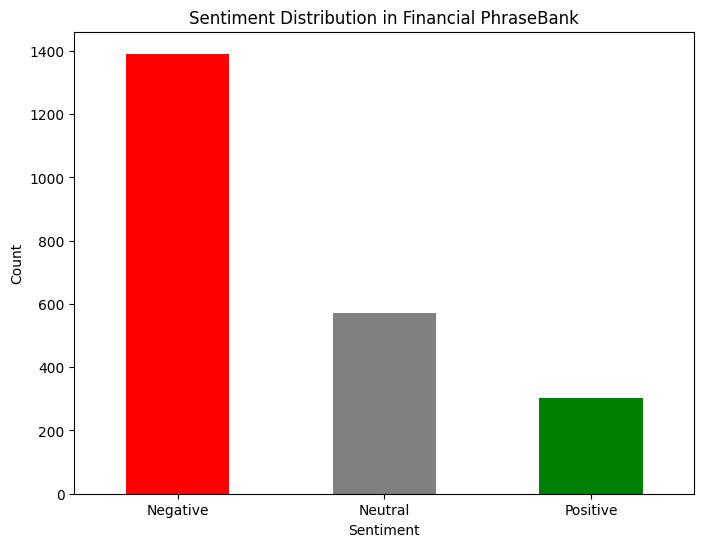


Example Sentences:
neutral: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
positive: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
positive: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .


In [3]:
# Step 2.5: Analyze the dataset

# dataset = load_dataset("takala/financial_phrasebank", "sentences_allagree", trust_remote_code=True),
# print(f"Type of dataset: {type(dataset)}")
# print(f"Dataset contents: {dataset}")
# df = pd.DataFrame(dataset['train'])
# print("Dataset Size:", len(df))
# print("\nSentiment Distribution:")
# sentiment_counts = df['label'].value_counts()
# sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
# print(sentiment_counts.replace(sentiment_map))
dataset = load_dataset("takala/financial_phrasebank", "sentences_allagree", trust_remote_code=True)

# Check if it's a DatasetDict
if isinstance(dataset, dict) and 'train' in dataset:
    df = pd.DataFrame(dataset['train'])
else:
    # If it's a tuple or unexpected format, inspect and adjust
    print(f"Unexpected dataset type: {type(dataset)}")
    print(f"Dataset contents: {dataset}")
    # Assuming the first element is the train split (common for some datasets)
    df = pd.DataFrame(dataset[0])  # Try this if it’s a tuple

print("Dataset Size:", len(df))
print("\nSentiment Distribution:")
sentiment_counts = df['label'].value_counts()
sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
print(sentiment_counts.replace(sentiment_map))

df['sentence_length'] = df['sentence'].apply(lambda x: len(x.split()))
print("\nSentence Length Statistics:")
print(df['sentence_length'].describe())
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Sentiment Distribution in Financial PhraseBank')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], rotation=0)
plt.show()
print("\nExample Sentences:")
for i in range(3):
    print(f"{sentiment_map[df['label'][i]]}: {df['sentence'][i]}")

In [4]:
# Step 3: Prepare the dataset
def format_example(example):
    sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
    prompt = f"<|begin_of_text|>Classify the sentiment of this financial statement: {example['sentence']}\n\n"
    response = f"The sentiment is {sentiment_map[example['label']]}.<|eot_id>"
    return {"text": f"{prompt}\n\n{response}"}

formatted_dataset = dataset.map(format_example)
train_dataset = formatted_dataset["train"].train_test_split(test_size=0.2)
print(train_dataset['train'][0])

{'sentence': 'ADPnews - Jul 17 , 2009 - Finland-based steel maker Rautaruukki Oyj Ruukki HEL : RTRKS said today it slipped to a net loss of EUR 184 million USD 259.7 m for the first half of 2009 from a net profit of EUR 2', 'label': 0, 'text': '<|begin_of_text|>Classify the sentiment of this financial statement: ADPnews - Jul 17 , 2009 - Finland-based steel maker Rautaruukki Oyj Ruukki HEL : RTRKS said today it slipped to a net loss of EUR 184 million USD 259.7 m for the first half of 2009 from a net profit of EUR 2\n\n\n\nThe sentiment is negative.<|eot_id>'}


In [5]:

# Step 4: Load Llama 3 with 4-bit quantization
model_name = "meta-llama/Meta-Llama-3-8B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16  # Use torch.float16 directly
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"  # Automatically maps to your GPU
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 4/4 [00:13<00:00,  3.38s/it]


In [6]:
# Step 5: Configure LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

In [ ]:
# Step 6: Set up the trainer
training_args = TrainingArguments(
    output_dir="../models/llama3_finetuned",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=10,
    warmup_steps=20,
    logging_steps=10,
    save_steps=50,
    optim="paged_adamw_8bit",
    fp16=True,
    evaluation_strategy="steps",
    eval_steps=50,
)
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset["train"],
    eval_dataset=train_dataset["test"],
    args=training_args
)

c:\Users\Jayden\Desktop\llm_fyp_finbert\.venv\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Jayden\AppData\Local\Temp\ipykernel_7020\950563792.py:16: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
Tokenizing eval dataset: 100%|██████████| 453/453 [00:00<00:00, 13210.45 examples/s]
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [8]:
# Step 7: Fine-tune the model
trainer.train()

Step,Training Loss,Validation Loss
50,1.901900,1.909111
100,1.539800,1.486304
150,1.345500,1.440792
200,1.336200,1.420034
250,1.196800,1.415123
300,1.284400,1.403291
350,1.397100,1.406124
400,1.306600,1.397535
450,1.344600,1.390632
500,1.194000,1.411987


TrainOutput(global_step=2260, training_loss=0.8797270191454254, metrics={'train_runtime': 3882.3138, 'train_samples_per_second': 4.665, 'train_steps_per_second': 0.582, 'total_flos': 4.719402653508403e+16, 'train_loss': 0.8797270191454254})

In [ ]:
# Step 8: Save the fine-tuned model
trainer.save_model("../models/llama3_finetuned_final")  # Final model

# Clear GPU memory
import torch
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Load base model and merge
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config
)
finetuned_model = PeftModel.from_pretrained(base_model, "../models/llama3_finetuned_final")
merged_model = finetuned_model.merge_and_unload()
merged_model.save_pretrained("../models/llama3_merged")
tokenizer.save_pretrained("../models/llama3_merged")

Loading checkpoint shards: 100%|██████████| 4/4 [00:14<00:00,  3.57s/it]
c:\Users\Jayden\Desktop\llm_fyp_finbert\.venv\Lib\site-packages\peft\tuners\lora\bnb.py:355: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


('../fine_tune_llm/models/llama3_merged\\tokenizer_config.json',
 '../fine_tune_llm/models/llama3_merged\\special_tokens_map.json',
 '../fine_tune_llm/models/llama3_merged\\tokenizer.json')

In [ ]:
# Step 9: Test the model
generator = pipeline("text-generation", model="../models/llama3_merged", tokenizer=tokenizer)
# prompt = "Classify the sentiment of this financial statement: 'The company saw a significant decline in revenue.'"
prompt = "Classify the sentiment of this financial statement: Tesla Prepares to Deploy Long-Awaited FSD Features in China.'"
output = generator(prompt, max_new_tokens=20, do_sample=False)
print(output[0]["generated_text"])

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.59s/it]
Device set to use cuda:0


Classify the sentiment of this financial statement: Tesla Prepares to Deploy Long-Awaited FSD Features in China.' ''



The sentiment is neutral.<|eot_id><|eot_id>1889






In [ ]:
# Clear GPU memory
torch.cuda.empty_cache()
print("GPU memory cleared.")

GPU memory cleared.


: 